In [1]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from itertools import product
from talib import abstract
from tqdm import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt

def talib_factor(df,ta_factor,close_column_name):
    """"
    调取talib的因子，按照默认参数进行求值
    """
    target_fun=abstract.Function(ta_factor)
    ta_values=target_fun(df)
    #下方的if-else是为了应对不同的结果，有的talib fun会返回多列，有的只返回一列
    #eg. MAXMIN返回 MAX 和 MIN两个值，这里进行特殊处理
    df['close']=df[close_column_name]
    if len(ta_values.shape)==1:
        ta_values=pd.DataFrame(ta_values,columns=[f'{close_column_name}_{ta_factor}'])
    else:
        ta_values=pd.DataFrame(ta_values)
        colname=ta_values.columns
        new_colname={}
        for col in colname:
            new_colname.update( {col:f'{close_column_name}_{col}'})
        ta_values.rename(columns=new_colname,inplace=True)
    return ta_values

def feature_extract_talib(df):
    """
        计算因子，对不同的特征进行提取：可转债本身的原始数据，利用人造kline计算需要Kline的因子
        而仅仅只能通过收盘价/成交价计算的因子，则只用ab合成价格和正股的kline进行计算
    """
    df=df.copy().sort_index()
    #only for kline
    ta_list_kline=['HT_DCPERIOD','HT_DCPHASE','HT_PHASOR','HT_SINE','HT_TRENDMODE','ADD',
    'DIV','APO','BOP','CCI','CMO','MACD','MFI','MOM','PPO','ROC','RSI','TRIX','WILLR',
    'BBANDS','DEMA','EMA','HT_TRENDLINE','KAMA','MA','MAMA','MIDPOINT','MIDPRICE','SAR',
    'SAREXT','SMA','T3','TEMA','TRIMA','WMA','AVGPRICE','MEDPRICE','TYPPRICE','WCLPRICE',
    'LINEARREG','LINEARREG_ANGLE','LINEARREG_INTERCEPT','LINEARREG_SLOPE','STDDEV','TSF',
    'TRANGE','AD','ADOSC','OBV']

    factors=[talib_factor(df,ta,close_column_name='close') for ta,colname\
        in tqdm([*product(ta_list_kline,('close',))],desc='adding talib factors')]
    df=pd.concat([df,*factors],axis=1)    
    return df

data=pd.read_csv("CU0.SHF.csv", index_col=0).drop(columns=['Contract'])
external_data=pd.read_csv('modified_external_data.csv',encoding='utf-8',sep=',')
data.reset_index(inplace=True)
data=data.rename(columns={'index':'date','Open_adj':'open','High_adj':'high','Low_adj':'low','Close_adj':'close','Volume':'volume'})
data=pd.merge(data,external_data,on='date',how='left')
data=feature_extract_talib(data)
data['return_5']=data['close'].pct_change(-5)
data=data.dropna()
data=data.drop(columns=['open','high','low','volume','Open_interest','close','date'])

adding talib factors: 100%|██████████| 49/49 [00:00<00:00, 2471.15it/s]


In [22]:
temp=data.copy()
val=temp.pop('return_5')
temp.insert(0,'return_5',val)
temp.corr()

,return_5,spot_LME,future_LME,Noncommercial_long_positions_COMEX,Noncommercial_short_positions_COMEX,spot_CN,spot_inventory_CN,inventory_COMEX,inventory_LME_asia,production_CN,...,close_LINEARREG,close_LINEARREG_ANGLE,close_LINEARREG_INTERCEPT,close_LINEARREG_SLOPE,close_STDDEV,close_TSF,close_TRANGE,close_AD,close_ADOSC,close_OBV
return_5,1.000000,0.067548,0.067346,-0.025731,-0.005552,0.033989,0.112119,-0.017542,0.087300,0.058140,...,0.060384,-0.051756,0.063746,-0.010118,-0.011605,0.059945,0.005172,0.008178,0.022855,-0.015173
spot_LME,0.067548,1.000000,0.999702,-0.104301,-0.582768,0.975291,0.055148,-0.056399,0.014386,-0.029283,...,0.912279,0.097732,0.891082,0.109666,0.266641,0.911121,0.274595,-0.177827,0.057179,-0.153879
future_LME,0.067346,0.999702,1.000000,-0.101503,-0.582682,0.976358,0.053229,-0.054574,0.014641,-0.029535,...,0.912774,0.098393,0.891675,0.109327,0.265536,0.911607,0.273134,-0.180697,0.059884,-0.155529
Noncommercial_long_positions_COMEX,-0.025731,-0.104301,-0.101503,1.000000,0.514686,-0.094910,0.057512,0.103571,0.003780,-0.050827,...,0.160959,0.055987,0.114780,0.174107,0.000544,0.163975,0.069893,0.589725,0.021656,0.678900
Noncommercial_short_positions_COMEX,-0.005552,-0.582768,-0.582682,0.514686,1.000000,-0.562377,-0.004691,0.025569,0.011955,0.057783,...,-0.349842,-0.104820,-0.332013,-0.077431,-0.187621,-0.350135,-0.157153,0.625487,-0.096298,0.620778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
close_TSF,0.059945,0.911121,0.911607,0.163975,-0.350135,0.931871,0.092015,-0.035352,0.007100,-0.033869,...,0.999790,0.142794,0.957067,0.191268,0.272116,1.000000,0.311336,0.111797,0.028439,0.183139
close_TRANGE,0.005172,0.274595,0.273134,0.069893,-0.157153,0.296234,0.066948,0.038406,-0.008755,0.005432,...,0.312797,-0.002649,0.319556,-0.013548,0.669348,0.311336,1.000000,-0.029778,0.019562,0.018339
close_AD,0.008178,-0.177827,-0.180697,0.589725,0.625487,-0.174910,0.029777,-0.013006,-0.029066,0.014116,...,0.111241,-0.016566,0.099478,0.046845,-0.108138,0.111797,-0.029778,1.000000,-0.054306,0.953020
close_ADOSC,0.022855,0.057179,0.059884,0.021656,-0.096298,0.039456,0.019832,-0.013413,-0.068897,-0.036616,...,0.020780,0.314983,-0.080962,0.371758,0.064284,0.028439,0.019562,-0.054306,1.000000,-0.049411


In [2]:
train_date_length=500
param = {
    'boosting_type': 'rf', # 使用Random Forests增强鲁棒性
    'objective': 'regression', # 回归问题
    'metric': 'mse', # 评价指标为MAE
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 3
}


trainset=np.array([data.iloc[i:i+train_date_length,:-1] for i in range(0,len(data)-train_date_length)])
trainset=trainset.reshape(-1,trainset.shape[1]*trainset.shape[2])
label=data.iloc[train_date_length:,-1].values


n=2000
train=lgb.Dataset(trainset[:n,:],label=label[:n])
mdoel=lgb.train(param,train,num_boost_round=100,)

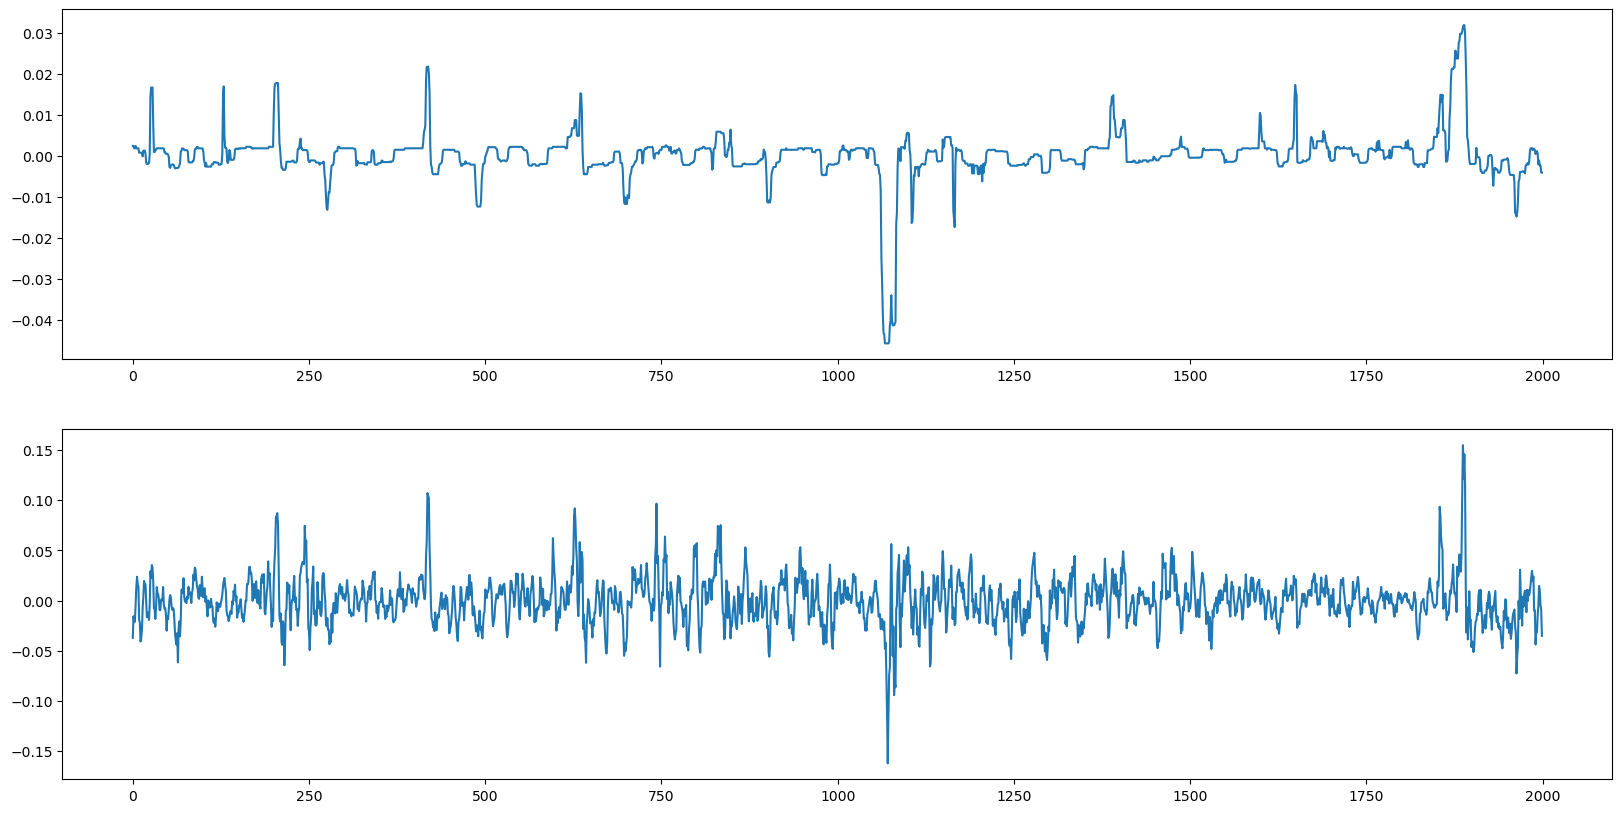

In [7]:
train_predict=mdoel.predict(trainset[:n,:])
train_real=label[:n]
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(train_predict)
ax[1].plot(train_real)


In [3]:
predict=mdoel.predict(trainset[n:,:])
real=label[n:]

In [4]:
result_df=pd.DataFrame({'predict':predict,'real':real})
result_df[(result_df['predict']>0)&(result_df['real']>0)].shape[0]/result_df[(result_df['real']>0)].shape[0]

0.7381818181818182

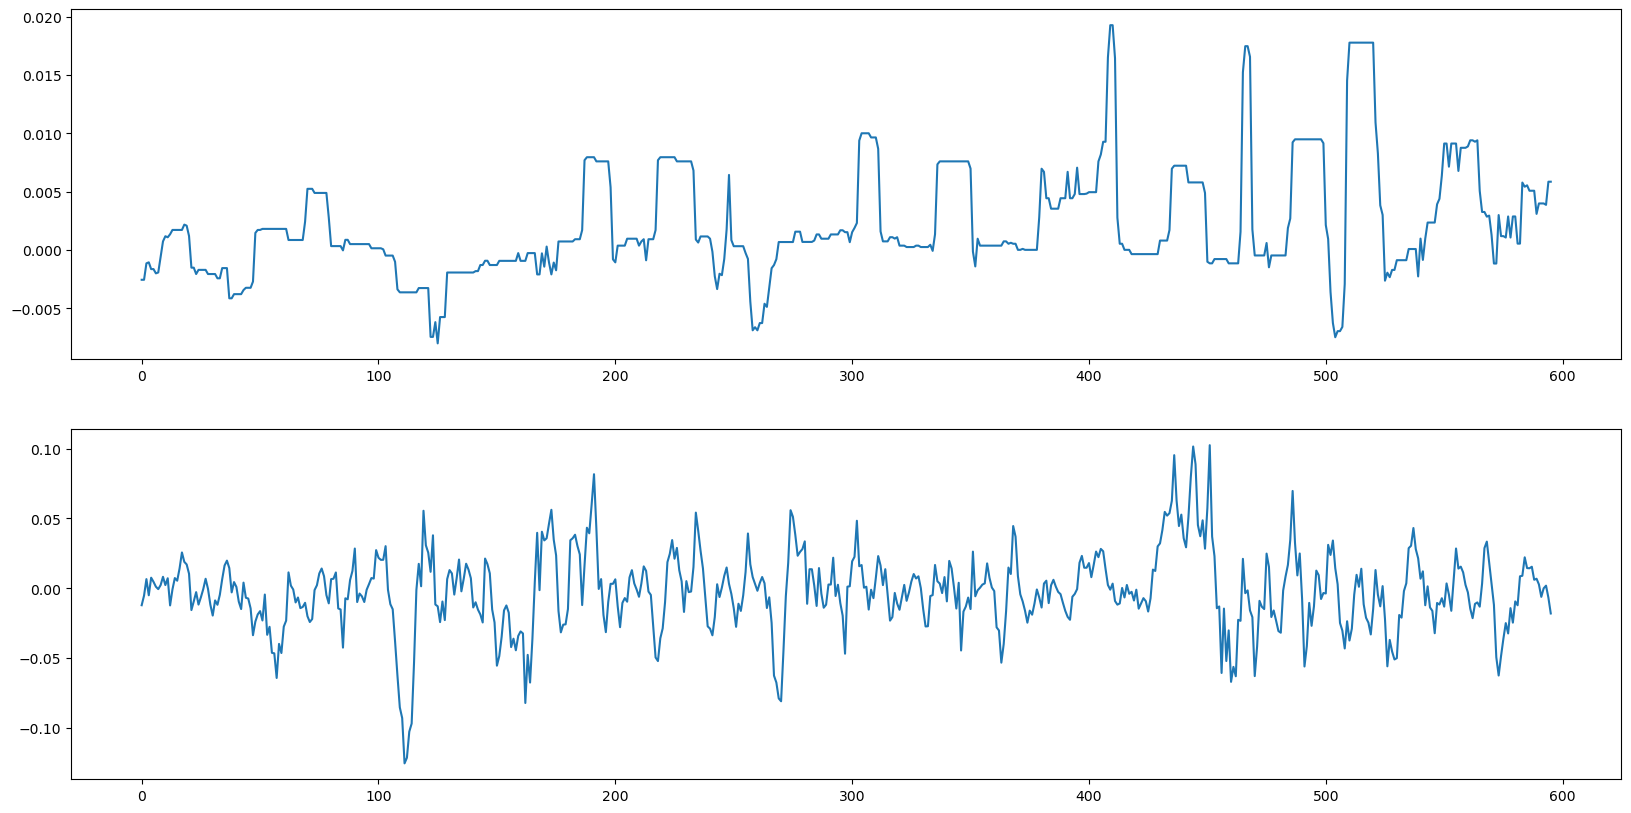

In [5]:
result_df=pd.DataFrame({'predict':predict,'real':real})
result_df[(result_df['predict']>0)&(result_df['real']>0)].shape[0]/result_df[(result_df['real']>0)].shape[0]
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(predict)
ax[1].plot(real)

In [23]:
train_date_length=500
predict_date_length=100
param = {
    'boosting_type': 'rf', # 使用Random Forests增强鲁棒性
    'objective': 'regression', # 回归问题
    'metric': 'mae', # 评价指标为MAE
    'num_leaves': 15,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'max_depth': 3
}


trainset=np.array([data.iloc[i:i+train_date_length,:-1] for i in range(0,len(data)-train_date_length)])
trainset=trainset.reshape(-1,trainset.shape[1]*trainset.shape[2])
label=data.iloc[train_date_length:,-1].values
window_size=500
model=None
y_real_list=[]
y_pred_list=[]
for i in tqdm(range(window_size,trainset.shape[0])):
    train_data=trainset[i-window_size:i,:]
    train_data=(train_data-train_data.mean(axis=0))/train_data.std(axis=0)
    train_label=label[i-window_size:i]
    rolling_trainset=lgb.Dataset(train_data,train_label)
    if model is None:
        model=lgb.train(param,rolling_trainset,num_boost_round=100)
    else:
        model=lgb.train(param,rolling_trainset,init_model=model,keep_training_booster=True)
    y_pred=model.predict(trainset[i,:].reshape(1,-1))
    y_pred_list.append(y_pred)
    y_real_list.append(label[i])

  0%|          | 1/2096 [00:10<5:52:51, 10.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.731059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5042297
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 33000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000001EC8D793820>
Traceback (most recent call last):
  File "c:\Users\61428\Anaconda3\lib\site-packages\lightgbm\basic.py", line 91, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po